In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from utils import windowed_dataset, build_basic_lstm,split_train_test,split_train_test_val
from config import *

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import datetime

import mlflow
mlflow.set_tracking_uri("file:///./mlruns")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

mpl.rcParams['figure.figsize'] = [35.0, 7.0]

today=datetime.date.today().strftime("%Y%m%d")
coefficients=17

rd_filename='tmp_residues_{}_{}.csv'.format(coefficients, today)
rd_feat_filename='tmp_residues_feat_{}_{}.csv'.format(coefficients, today)
rd_feat_norm_filename='tmp_residues_feat_norm_{}_{}.csv'.format(coefficients, today)

r_filename='tmp_radius_{}.csv'.format(today)
r_feat_filename='tmp_radius_feat_{}.csv'.format(today)
r_feat_norm_filename='tmp_radius_feat_norm_{}.csv'.format(today)

binary_labels_filename ='tmp_spiral_binaly_labels_{}.csv'.format(today)

%load_ext tensorboard

Current tracking uri: file:///./mlruns


In [2]:
# Clear any logs from previous runs
!rm -rf ./tensorflow_logs/

In [3]:
rd_df = pd.read_csv(rd_filename, index_col=0)
binary_labels = pd.read_csv(binary_labels_filename, index_col=0)

In [4]:
x=rd_df.values.astype('float32')
y=binary_labels.values.astype('int8').reshape(-1,1)
x.shape

(53, 4096)

Window function is applied to Dataset objects. Same windows lenghts for each time series corresponding to each subject are built asigning the rigth label. Then they are included in same Dataset object.

In [5]:
#windowing parameters
num_features = x.shape[1]
window_size = int(num_features/5 + 1)
shuffle_buffer = num_features
batch_size = 1

In [6]:
features=tf.data.Dataset.from_tensor_slices(x)
labels=(y)

In [7]:
#series, window_size, batch_size,label
for i,features in enumerate(x):
    new = windowed_dataset(features,window_size,batch_size,labels[i])
    if i>0:
        dataset = tf.data.Dataset.concatenate(dataset,new)
    else:
        dataset = new
        
dataset.cache()
dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int8, name=None))

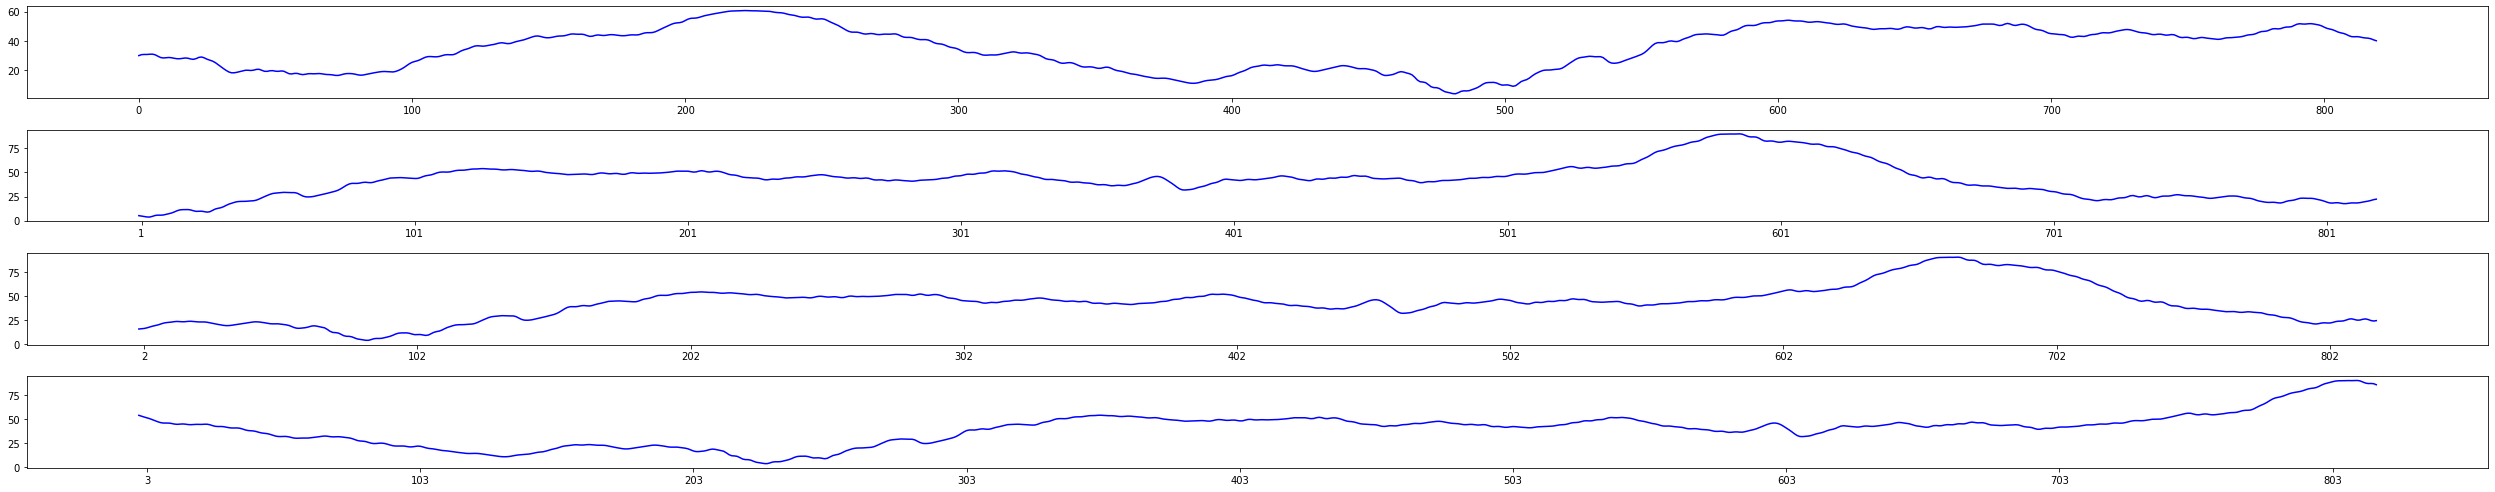

In [8]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(dataset.shuffle(1000).take(4),axes):
    ax.plot(feat.numpy(), color=colors[label.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    i+=1

We can apply filters to a Dataset object

In [9]:
positive_filter=lambda x,y: tf.equal(y, 1)[0]
negative_filter=lambda x,y: tf.equal(y, 0)[0]
positive_samples=dataset.filter(positive_filter).cache()
negative_samples=dataset.filter(negative_filter).cache()

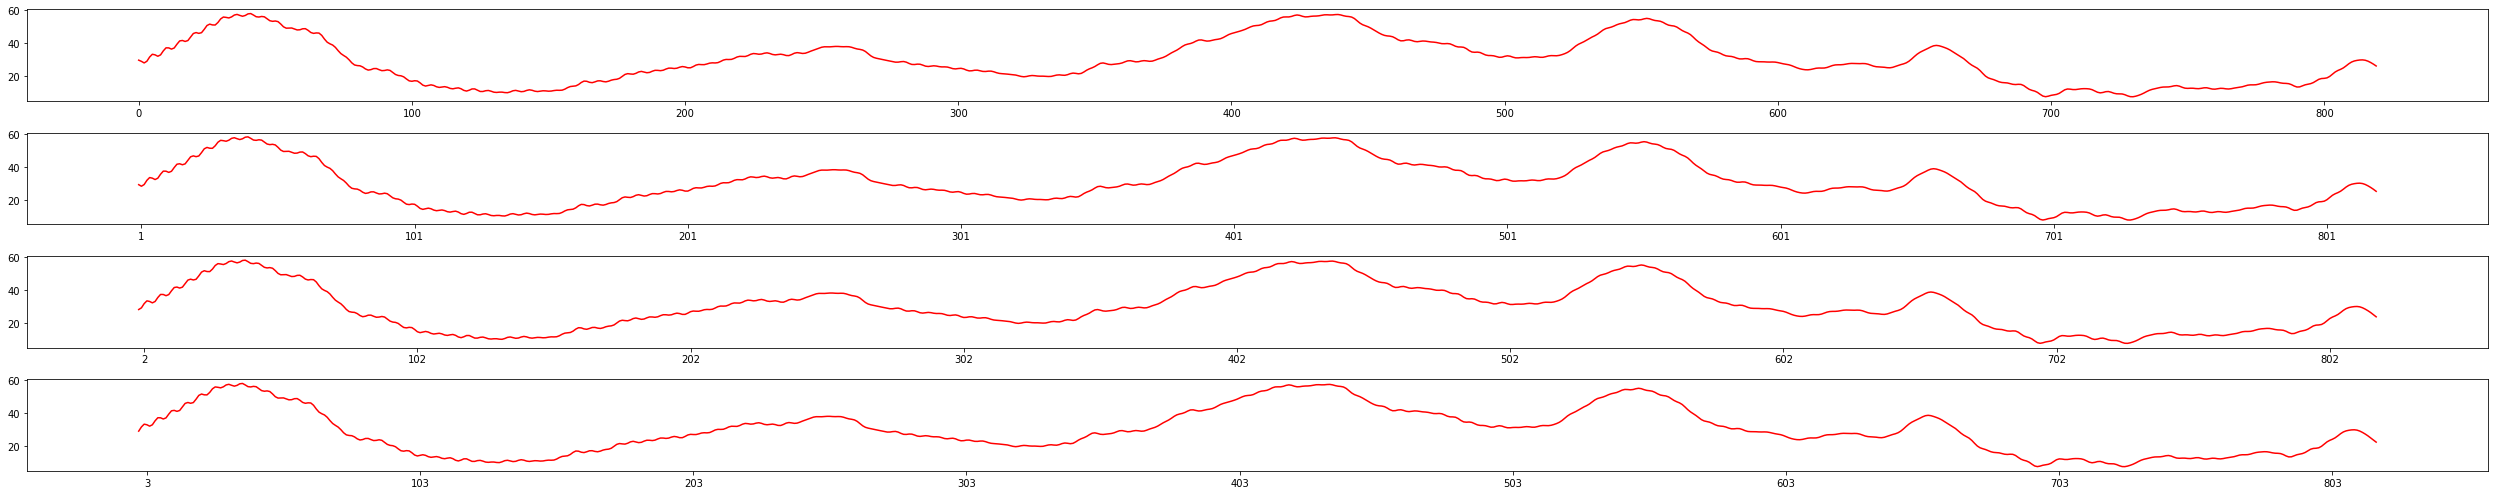

In [10]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(positive_samples.take(4), axes):
    ax.plot(feat.numpy(), color=colors[label.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    i+=1

It is possible to access just to one element using python iterator. In the example bellow it is showed also how to shuffle the dataset and batch together some examples into minibatches:

In [11]:
# iterator = iter(positive_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
# n_iterator = iter(negative_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
iterator = iter(positive_samples.batch(batch_size).cache())
n_iterator = iter(negative_samples.batch(batch_size).cache())

In [ ]:
first = iterator.next()
n_first = n_iterator.next()

plt.plot(first[0].numpy()[0], color=colors[first[1].numpy()[0][0]])
_=plt.plot(n_first[0].numpy()[0], color=colors[n_first[1].numpy()[0][0]])